In [ ]:
"""
=============================================================================
CAPSTONE BIG DATA PROJECT
01 - SPARK DATA CLEANING PIPELINE
=============================================================================
Author: [Your Name]
Date: December 2024
Project: E-commerce Delivery Risk Analytics

This notebook performs comprehensive data cleaning using Apache Spark:
- Data ingestion and schema inference
- Exploratory Data Analysis (EDA)
- Duplicate removal
- Date structure standardization
- Missing value handling
- Data quality validation
=============================================================================
"""

# =============================================================================
# CELL 1: INSTALLATION & SETUP
# =============================================================================
print("=" * 80)
print("🚀 INSTALLING PYSPARK")
print("=" * 80)

!pip install pyspark==3.4.1 -q
!pip install matplotlib seaborn -q

print("✅ Installation complete!")


🚀 INSTALLING PYSPARK
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.5/200.5 kB 7.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dataproc-spark-connect 1.0.1 requires pyspark[connect]~=4.0.0, but you have pyspark 3.4.1 which is incompatible.
✅ Installation complete!


In [ ]:
# =============================================================================
# CELL 2: IMPORTS
# =============================================================================
print("\n" + "=" * 80)
print("📦 IMPORTING LIBRARIES")
print("=" * 80)

from pyspark.sql import SparkSession
from pyspark.sql.functions import (
    col, count, when, isnan, isnull, sum as spark_sum,
    mean, stddev, min as spark_min, max as spark_max,
    to_date, to_timestamp, year, month, dayofmonth, dayofweek,
    datediff, current_timestamp, lit, trim, lower, upper,
    regexp_replace, countDistinct
)
from pyspark.sql.types import (
    StructType, StructField, StringType, IntegerType,
    DoubleType, DateType, TimestampType
)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import time

print("✅ All libraries imported successfully!")



📦 IMPORTING LIBRARIES
✅ All libraries imported successfully!


In [ ]:
# =============================================================================
# CELL 3: CREATE SPARK SESSION
# =============================================================================
print("\n" + "=" * 80)
print("⚡ CREATING SPARK SESSION")
print("=" * 80)

spark = SparkSession.builder \
    .appName("E-commerce_Data_Cleaning") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.memory", "4g") \
    .config("spark.sql.shuffle.partitions", "200") \
    .config("spark.sql.adaptive.enabled", "true") \
    .config("spark.sql.adaptive.coalescePartitions.enabled", "true") \
    .master("local[*]") \
    .getOrCreate()

spark.sparkContext.setLogLevel("ERROR")

print(f"✅ Spark Version: {spark.version}")
print(f"✅ Master: {spark.sparkContext.master}")
print(f"✅ Available Cores: {spark.sparkContext.defaultParallelism}")
print("=" * 80)


⚡ CREATING SPARK SESSION
✅ Spark Version: 3.4.1
✅ Master: local[*]
✅ Available Cores: 2


In [ ]:
# =============================================================================
# CELL 4: UPLOAD DATASET
# =============================================================================
print("\n" + "=" * 80)
print("📁 UPLOAD YOUR DATASET")
print("=" * 80)

from google.colab import files
uploaded = files.upload()

# Get the filename
filename = list(uploaded.keys())[0]
print(f"\n✅ File uploaded: {filename}")


📁 UPLOAD YOUR DATASET


Saving datasetsupplychain.csv to datasetsupplychain.csv

✅ File uploaded: datasetsupplychain.csv


In [ ]:
# =============================================================================
# CELL 5: DATA INGESTION
# =============================================================================
print("\n" + "=" * 80)
print("📥 INGESTING DATA WITH SPARK")
print("=" * 80)

start_time = time.time()

# Read CSV with schema inference
df_raw = spark.read \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .option("multiLine", "true") \
    .option("escape", "\"") \
    .csv(filename)

ingestion_time = time.time() - start_time

print(f"✅ Data loaded in {ingestion_time:.2f} seconds")
print(f"📊 Rows: {df_raw.count():,}")
print(f"📊 Columns: {len(df_raw.columns)}")

# Cache for faster operations
df_raw.cache()
print("✅ Data cached in memory")



📥 INGESTING DATA WITH SPARK
✅ Data loaded in 12.23 seconds
📊 Rows: 180,519
📊 Columns: 60
✅ Data cached in memory


In [ ]:
# =============================================================================
# CELL 6: SCHEMA ANALYSIS
# =============================================================================
print("\n" + "=" * 80)
print("📋 SCHEMA ANALYSIS")
print("=" * 80)

print("\n🔍 Data Schema:")
df_raw.printSchema()

print("\n📊 Column Types Distribution:")
type_counts = {}
for field in df_raw.schema.fields:
    dtype = str(field.dataType)
    type_counts[dtype] = type_counts.get(dtype, 0) + 1

for dtype, count in sorted(type_counts.items()):
    print(f"  • {dtype}: {count} columns")


📋 SCHEMA ANALYSIS

🔍 Data Schema:
root
 |-- Type: string (nullable = true)
 |-- Days for shipping (real): integer (nullable = true)
 |-- Days for shipment (scheduled): integer (nullable = true)
 |-- Benefit per order: double (nullable = true)
 |-- Sales per customer: double (nullable = true)
 |-- Delivery Status: string (nullable = true)
 |-- Late_delivery_risk: integer (nullable = true)
 |-- Category Id: integer (nullable = true)
 |-- Category Name: string (nullable = true)
 |-- Customer City: string (nullable = true)
 |-- Customer Fname: string (nullable = true)
 |-- Customer Id: integer (nullable = true)
 |-- Customer Lname: string (nullable = true)
 |-- Customer Segment: string (nullable = true)
 |-- Customer Zipcode: integer (nullable = true)
 |-- Department Id: integer (nullable = true)
 |-- Department Name: string (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Market: string (nullable = true)
 |-- Order City: string (null

In [ ]:
# =============================================================================
# CELL 7: INITIAL DATA PREVIEW
# =============================================================================
print("\n" + "=" * 80)
print("👀 INITIAL DATA PREVIEW")
print("=" * 80)

print("\n📊 First 5 rows:")
df_raw.show(5, truncate=True)

print("\n📊 Sample of key columns:")
key_cols = ['Type', 'Delivery Status', 'Category Name', 'Customer City',
            'Order Country', 'Sales', 'order date (DateOrders)']
existing_cols = [c for c in key_cols if c in df_raw.columns]
df_raw.select(existing_cols).show(5, truncate=True)


👀 INITIAL DATA PREVIEW

📊 First 5 rows:
+--------+------------------------+-----------------------------+-----------------+------------------+----------------+------------------+-----------+--------------+-------------+--------------+-----------+--------------+----------------+----------------+-------------+---------------+-----------+------------+------------+----------------+--------------------+-----------------+-----------------------+--------+----------------------+-------------------+------------------------+-------------+------------------------+-----------------------+-------------------+-----------+----------------+----------------------+---------------+------------+---------------+-------------------+--------------------+-------------+--------------------------+--------------+--------------------+---------------+---------------+----------------+--------------+--------------------+-----------------------+------------------+------------------+-------------------+--------------

In [ ]:
# =============================================================================
# CELL 8: EXPLORATORY DATA ANALYSIS (EDA) - PART 1
# =============================================================================
print("\n" + "=" * 80)
print("📊 EXPLORATORY DATA ANALYSIS - PART 1: MISSING VALUES")
print("=" * 80)

# Calculate missing values for each column
missing_stats = []

for col_name in df_raw.columns:
    null_count = df_raw.filter(
        col(col_name).isNull() |
        isnan(col(col_name)) |
        (col(col_name) == "") |
        (col(col_name) == " ")
    ).count()

    total_count = df_raw.count()
    missing_pct = (null_count / total_count) * 100

    missing_stats.append({
        'Column': col_name,
        'Missing_Count': null_count,
        'Missing_Percentage': round(missing_pct, 2)
    })

# Convert to Pandas for display
missing_df = pd.DataFrame(missing_stats)
missing_df = missing_df.sort_values('Missing_Percentage', ascending=False)

print("\n🔍 Missing Values Summary:")
print(missing_df[missing_df['Missing_Count'] > 0].to_string(index=False))

# Visualize missing values
plt.figure(figsize=(12, 6))
top_missing = missing_df[missing_df['Missing_Percentage'] > 0].head(15)
plt.barh(top_missing['Column'], top_missing['Missing_Percentage'])
plt.xlabel('Missing Percentage (%)')
plt.title('Top 15 Columns with Missing Values')
plt.tight_layout()
plt.show()



📊 EXPLORATORY DATA ANALYSIS - PART 1: MISSING VALUES


AnalysisException: [DATATYPE_MISMATCH.UNEXPECTED_INPUT_TYPE] Cannot resolve "isnan(order_date_timestamp)" due to data type mismatch: Parameter 1 requires the ("DOUBLE" or "FLOAT") type, however "order_date_timestamp" has the type "TIMESTAMP".;
'Filter (((isnull(order_date_timestamp#43) OR isnan(order_date_timestamp#43)) OR (order_date_timestamp#43 = cast( as timestamp))) OR (order_date_timestamp#43 = cast(  as timestamp)))
+- Relation [Type#0,Days for shipping (real)#1,Days for shipment (scheduled)#2,Benefit per order#3,Sales per customer#4,Delivery Status#5,Late_delivery_risk#6,Category Id#7,Category Name#8,Customer City#9,Customer Fname#10,Customer Id#11,Customer Lname#12,Customer Segment#13,Customer Zipcode#14,Department Id#15,Department Name#16,Latitude#17,Longitude#18,Market#19,Order City#20,Order Country#21,Order Customer Id#22,order date (DateOrders)#23,... 36 more fields] csv


In [ ]:
# =============================================================================
# CELL 9: EDA - PART 2: DUPLICATE ANALYSIS
# =============================================================================
print("\n" + "=" * 80)
print("📊 EDA - PART 2: DUPLICATE ANALYSIS")
print("=" * 80)

total_rows = df_raw.count()
distinct_rows = df_raw.distinct().count()
duplicate_count = total_rows - distinct_rows
duplicate_pct = (duplicate_count / total_rows) * 100

print(f"\n📈 Duplicate Statistics:")
print(f"  • Total rows: {total_rows:,}")
print(f"  • Distinct rows: {distinct_rows:,}")
print(f"  • Duplicates: {duplicate_count:,} ({duplicate_pct:.2f}%)")

# Check duplicates based on Order Id
if 'Order Id' in df_raw.columns:
    order_duplicates = df_raw.groupBy('Order Id').count() \
        .filter(col('count') > 1).count()
    print(f"  • Duplicate Order IDs: {order_duplicates:,}")


📊 EDA - PART 2: DUPLICATE ANALYSIS

📈 Duplicate Statistics:
  • Total rows: 180,519
  • Distinct rows: 180,519
  • Duplicates: 0 (0.00%)
  • Duplicate Order IDs: 45,902



📊 EDA - PART 3: NUMERIC STATISTICS

📊 Found 37 numeric columns

📈 Statistical Summary:
+-------+------------------+------------------+-------------------+------------------------+----------------------+
|summary|             Sales| Benefit per order|Order Item Quantity|Order Item Product Price|Order Profit Per Order|
+-------+------------------+------------------+-------------------+------------------------+----------------------+
|  count|            180519|            180519|             180519|                  180519|                180519|
|   mean|203.77209608627513|21.974988638593906|  2.127637533999191|      141.23254992872495|    21.974988638593906|
| stddev|132.27307749970353|104.43352574698615| 1.4534514814226491|      139.73249200374246|    104.43352574698615|
|    min|       9.989999771|       -4274.97998|                  1|             9.989999771|           -4274.97998|
|    max|        1999.98999|       911.7999878|                  5|              1999.98999|        

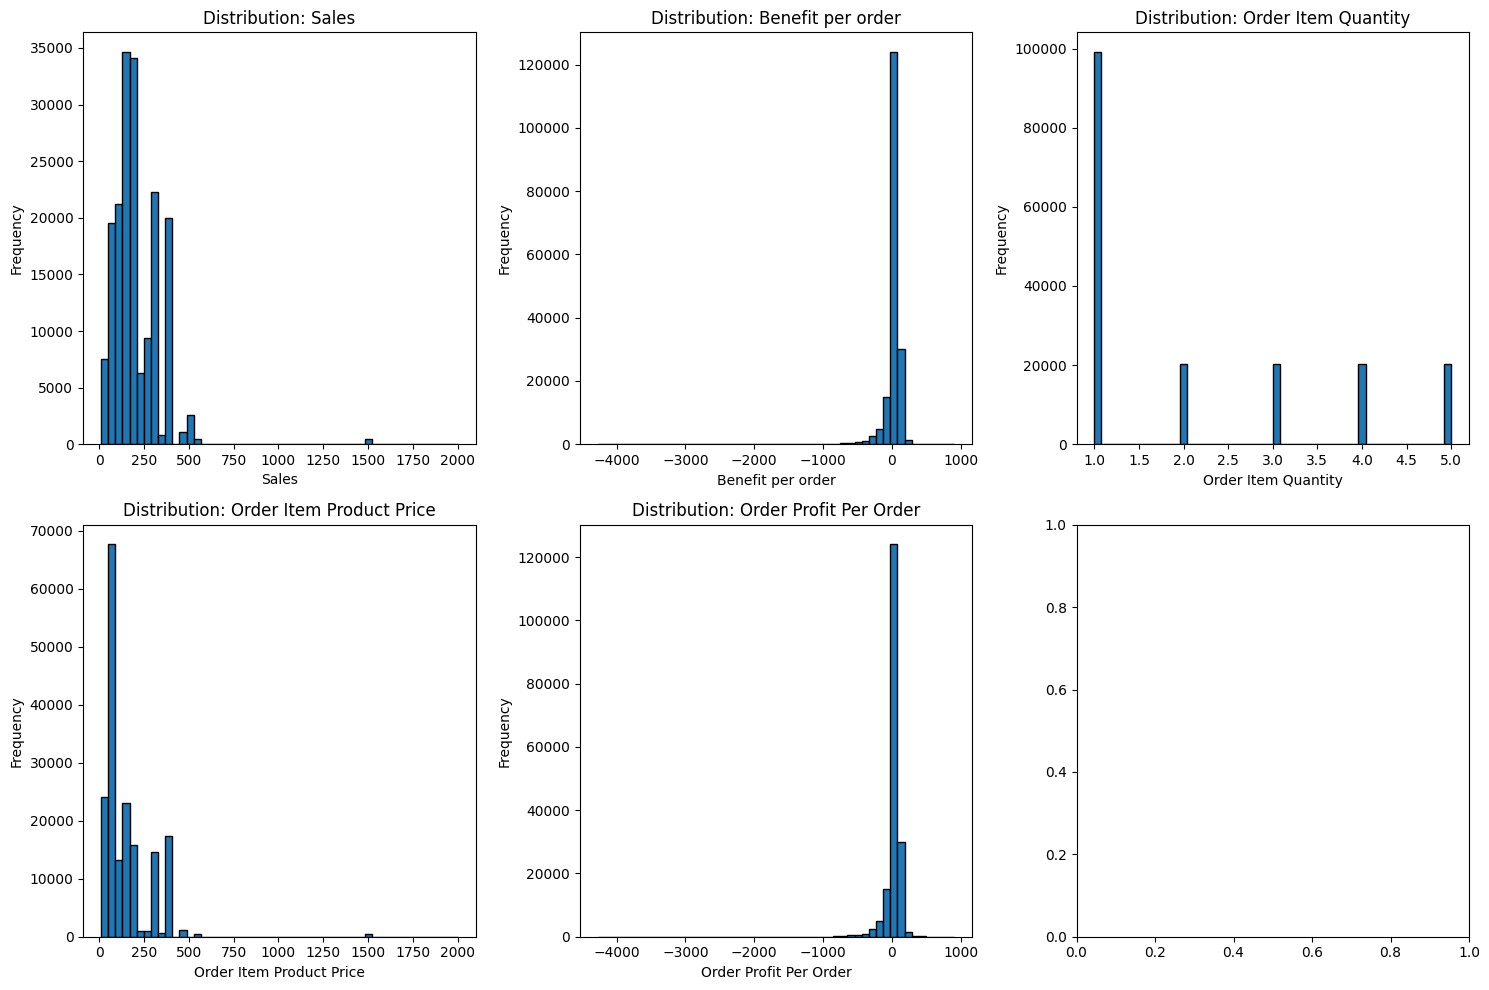

In [ ]:
# =============================================================================
# CELL 10: EDA - PART 3: NUMERIC STATISTICS
# =============================================================================
print("\n" + "=" * 80)
print("📊 EDA - PART 3: NUMERIC STATISTICS")
print("=" * 80)

# Get numeric columns
numeric_cols = [f.name for f in df_raw.schema.fields
                if isinstance(f.dataType, (IntegerType, DoubleType))]

print(f"\n📊 Found {len(numeric_cols)} numeric columns")

# Display statistics for key numeric columns
key_numeric = ['Sales', 'Benefit per order', 'Order Item Quantity',
               'Order Item Product Price', 'Order Profit Per Order']
existing_numeric = [c for c in key_numeric if c in df_raw.columns]

if existing_numeric:
    print("\n📈 Statistical Summary:")
    df_raw.select(existing_numeric).describe().show()

    # Distribution visualization
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.ravel()

    for idx, col_name in enumerate(existing_numeric[:6]):
        pandas_data = df_raw.select(col_name).toPandas()
        axes[idx].hist(pandas_data[col_name].dropna(), bins=50, edgecolor='black')
        axes[idx].set_title(f'Distribution: {col_name}')
        axes[idx].set_xlabel(col_name)
        axes[idx].set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()


In [ ]:
# =============================================================================
# CELL 11: EDA - PART 4: CATEGORICAL ANALYSIS
# =============================================================================
print("\n" + "=" * 80)
print("📊 EDA - PART 4: CATEGORICAL ANALYSIS")
print("=" * 80)

# Analyze key categorical columns
categorical_cols = ['Type', 'Delivery Status', 'Category Name',
                   'Customer Segment', 'Order Status', 'Shipping Mode']

for col_name in categorical_cols:
    if col_name in df_raw.columns:
        print(f"\n📊 {col_name} Distribution:")
        df_raw.groupBy(col_name).count() \
            .orderBy(col('count').desc()) \
            .show(10, truncate=False)


📊 EDA - PART 4: CATEGORICAL ANALYSIS

📊 Type Distribution:
+--------+-----+
|Type    |count|
+--------+-----+
|DEBIT   |69295|
|TRANSFER|49883|
|PAYMENT |41725|
|CASH    |19616|
+--------+-----+


📊 Delivery Status Distribution:
+-----------------+-----+
|Delivery Status  |count|
+-----------------+-----+
|Late delivery    |98977|
|Advance shipping |41592|
|Shipping on time |32196|
|Shipping canceled|7754 |
+-----------------+-----+


📊 Category Name Distribution:
+--------------------+-----+
|Category Name       |count|
+--------------------+-----+
|Cleats              |24551|
|Men's Footwear      |22246|
|Women's Apparel     |21035|
|Indoor/Outdoor Games|19298|
|Fishing             |17325|
|Water Sports        |15540|
|Camping & Hiking    |13729|
|Cardio Equipment    |12487|
|Shop By Sport       |10984|
|Electronics         |3156 |
+--------------------+-----+
only showing top 10 rows


📊 Customer Segment Distribution:
+----------------+-----+
|Customer Segment|count|
+-------------

In [ ]:
# =============================================================================
# CELL 12: EDA - PART 5: DATE ANALYSIS
# =============================================================================
print("\n" + "=" * 80)
print("📊 EDA - PART 5: DATE COLUMNS ANALYSIS")
print("=" * 80)

date_cols = [c for c in df_raw.columns if 'date' in c.lower()]
print(f"\n📅 Found {len(date_cols)} date columns: {date_cols}")

for date_col in date_cols:
    print(f"\n🔍 Analyzing: {date_col}")
    df_raw.select(date_col).show(5, truncate=False)

    # Check date format
    sample_dates = df_raw.select(date_col).limit(10).toPandas()
    print(f"  Sample values: {sample_dates[date_col].tolist()[:3]}")


📊 EDA - PART 5: DATE COLUMNS ANALYSIS

📅 Found 14 date columns: ['order date (DateOrders)', 'shipping date (DateOrders)', 'order_date_timestamp', 'order_date_date', 'order_date_year', 'order_date_month', 'order_date_day', 'order_date_dayofweek', 'shipping_date_timestamp', 'shipping_date_date', 'shipping_date_year', 'shipping_date_month', 'shipping_date_day', 'shipping_date_dayofweek']

🔍 Analyzing: order date (DateOrders)
+-----------------------+
|order date (DateOrders)|
+-----------------------+
|10/6/2016 14:51        |
|1/12/2018 18:14        |
|8/7/2015 8:48          |
|6/2/2015 10:38         |
|12/5/2015 0:13         |
+-----------------------+
only showing top 5 rows

  Sample values: ['10/6/2016 14:51', '1/12/2018 18:14', '8/7/2015 8:48']

🔍 Analyzing: shipping date (DateOrders)
+--------------------------+
|shipping date (DateOrders)|
+--------------------------+
|10/12/2016 14:51          |
|1/15/2018 18:14           |
|8/13/2015 8:48            |
|6/7/2015 10:38           

TypeError: Casting to unit-less dtype 'datetime64' is not supported. Pass e.g. 'datetime64[ns]' instead.

In [ ]:
# =============================================================================
# CELL 13: DATA CLEANING - STEP 1: REMOVE DUPLICATES
# =============================================================================
print("\n" + "=" * 80)
print("🧹 DATA CLEANING - STEP 1: REMOVING DUPLICATES")
print("=" * 80)

rows_before = df_raw.count()
df_clean = df_raw.dropDuplicates()
rows_after = df_clean.count()
duplicates_removed = rows_before - rows_after

print(f"✅ Rows before: {rows_before:,}")
print(f"✅ Rows after: {rows_after:,}")
print(f"✅ Duplicates removed: {duplicates_removed:,} ({(duplicates_removed/rows_before)*100:.2f}%)")

df_clean.cache()


🧹 DATA CLEANING - STEP 1: REMOVING DUPLICATES
✅ Rows before: 180,519
✅ Rows after: 180,519
✅ Duplicates removed: 0 (0.00%)


DataFrame[Type: string, Days for shipping (real): int, Days for shipment (scheduled): int, Benefit per order: double, Sales per customer: double, Delivery Status: string, Late_delivery_risk: int, Category Id: int, Category Name: string, Customer City: string, Customer Fname: string, Customer Id: int, Customer Lname: string, Customer Segment: string, Customer Zipcode: int, Department Id: int, Department Name: string, Latitude: double, Longitude: double, Market: string, Order City: string, Order Country: string, Order Customer Id: int, order date (DateOrders): string, Order Id: int, Order Item Cardprod Id: int, Order Item Discount: double, Order Item Discount Rate: double, Order Item Id: int, Order Item Product Price: double, Order Item Profit Ratio: double, Order Item Quantity: int, Sales: double, Order Item Total: double, Order Profit Per Order: double, Order Region: string, Order Status: string, Product Card Id: int, Product Category Id: int, Product Name: string, Product Price: doubl

In [ ]:
# =============================================================================
# CELL 14: DATA CLEANING - STEP 2: STANDARDIZE DATE COLUMNS
# =============================================================================
print("\n" + "=" * 80)
print("🧹 DATA CLEANING - STEP 2: STANDARDIZING DATE COLUMNS")
print("=" * 80)

# Function to parse dates in format: M/d/yyyy H:mm
def clean_dates(df, date_columns):
    """
    Standardize date columns to proper timestamp format
    """
    df_result = df

    for date_col in date_columns:
        if date_col in df.columns:
            print(f"\n🔧 Processing: {date_col}")

            # Convert to timestamp
            new_col_name = date_col.replace(' (DateOrders)', '').replace(' ', '_')

            df_result = df_result.withColumn(
                new_col_name + '_timestamp',
                to_timestamp(col(date_col), 'M/d/yyyy H:mm')
            )

            # Extract date
            df_result = df_result.withColumn(
                new_col_name + '_date',
                to_date(col(new_col_name + '_timestamp'))
            )

            # Extract components
            df_result = df_result.withColumn(
                new_col_name + '_year',
                year(col(new_col_name + '_timestamp'))
            )

            df_result = df_result.withColumn(
                new_col_name + '_month',
                month(col(new_col_name + '_timestamp'))
            )

            df_result = df_result.withColumn(
                new_col_name + '_day',
                dayofmonth(col(new_col_name + '_timestamp'))
            )

            df_result = df_result.withColumn(
                new_col_name + '_dayofweek',
                dayofweek(col(new_col_name + '_timestamp'))
            )

            print(f"  ✓ Created: {new_col_name}_timestamp")
            print(f"  ✓ Created: {new_col_name}_date")
            print(f"  ✓ Created: {new_col_name}_year, month, day, dayofweek")

    return df_result

# Apply date cleaning
date_columns = ['order date (DateOrders)', 'shipping date (DateOrders)']
df_clean = clean_dates(df_clean, date_columns)

print("\n✅ Date standardization complete!")

# Show sample of new date columns
print("\n📊 Sample of cleaned dates:")
date_display_cols = [c for c in df_clean.columns if 'timestamp' in c or 'date' in c]
df_clean.select(date_display_cols[:5]).show(5, truncate=False)



🧹 DATA CLEANING - STEP 2: STANDARDIZING DATE COLUMNS

🔧 Processing: order date (DateOrders)
  ✓ Created: order_date_timestamp
  ✓ Created: order_date_date
  ✓ Created: order_date_year, month, day, dayofweek

🔧 Processing: shipping date (DateOrders)
  ✓ Created: shipping_date_timestamp
  ✓ Created: shipping_date_date
  ✓ Created: shipping_date_year, month, day, dayofweek

✅ Date standardization complete!

📊 Sample of cleaned dates:
+-----------------------+--------------------------+--------------------+---------------+---------------+
|order date (DateOrders)|shipping date (DateOrders)|order_date_timestamp|order_date_date|order_date_year|
+-----------------------+--------------------------+--------------------+---------------+---------------+
|12/9/2016 21:04        |12/11/2016 21:04          |2016-12-09 21:04:00 |2016-12-09     |2016           |
|10/17/2016 3:06        |10/19/2016 3:06           |2016-10-17 03:06:00 |2016-10-17     |2016           |
|5/9/2017 12:17         |5/11/2017

In [ ]:
# =============================================================================
# CELL 12: EDA - PART 5: DATE ANALYSIS
# =============================================================================
print("\n" + "=" * 80)
print("📊 EDA - PART 5: DATE COLUMNS ANALYSIS")
print("=" * 80)

date_cols = [c for c in df_raw.columns if 'date' in c.lower()]
print(f"\n📅 Found {len(date_cols)} date columns: {date_cols}")

for date_col in date_cols:
    print(f"\n🔍 Analyzing: {date_col}")
    df_raw.select(date_col).show(5, truncate=False)

    # Check date format
    sample_dates = df_raw.select(date_col).limit(10).toPandas()
    print(f"  Sample values: {sample_dates[date_col].tolist()[:3]}")


📊 EDA - PART 5: DATE COLUMNS ANALYSIS

📅 Found 14 date columns: ['order date (DateOrders)', 'shipping date (DateOrders)', 'order_date_timestamp', 'order_date_date', 'order_date_year', 'order_date_month', 'order_date_day', 'order_date_dayofweek', 'shipping_date_timestamp', 'shipping_date_date', 'shipping_date_year', 'shipping_date_month', 'shipping_date_day', 'shipping_date_dayofweek']

🔍 Analyzing: order date (DateOrders)
+-----------------------+
|order date (DateOrders)|
+-----------------------+
|10/6/2016 14:51        |
|1/12/2018 18:14        |
|8/7/2015 8:48          |
|6/2/2015 10:38         |
|12/5/2015 0:13         |
+-----------------------+
only showing top 5 rows

  Sample values: ['10/6/2016 14:51', '1/12/2018 18:14', '8/7/2015 8:48']

🔍 Analyzing: shipping date (DateOrders)
+--------------------------+
|shipping date (DateOrders)|
+--------------------------+
|10/12/2016 14:51          |
|1/15/2018 18:14           |
|8/13/2015 8:48            |
|6/7/2015 10:38           

TypeError: Casting to unit-less dtype 'datetime64' is not supported. Pass e.g. 'datetime64[ns]' instead.

In [ ]:
# =============================================================================
# CELL 15: DATA CLEANING - STEP 3: HANDLE MISSING VALUES
# =============================================================================
print("\n" + "=" * 80)
print("🧹 DATA CLEANING - STEP 3: HANDLING MISSING VALUES")
print("=" * 80)

# Strategy:
# 1. Numeric columns: fill with median
# 2. Categorical columns: fill with mode or 'UNKNOWN'
# 3. Drop columns with >50% missing

# Identify columns to drop (>50% missing)
cols_to_drop = []
for col_name in df_clean.columns:
    null_count = df_clean.filter(col(col_name).isNull()).count()
    null_pct = (null_count / df_clean.count()) * 100

    if null_pct > 50:
        cols_to_drop.append(col_name)
        print(f"  ⚠️ Dropping {col_name} ({null_pct:.1f}% missing)")

if cols_to_drop:
    df_clean = df_clean.drop(*cols_to_drop)
    print(f"\n✅ Dropped {len(cols_to_drop)} columns with >50% missing")

# Fill numeric columns with median
numeric_cols = [f.name for f in df_clean.schema.fields
                if isinstance(f.dataType, (IntegerType, DoubleType))]

for col_name in numeric_cols:
    median_val = df_clean.approxQuantile(col_name, [0.5], 0.01)[0]
    df_clean = df_clean.fillna({col_name: median_val})
    print(f"  ✓ Filled {col_name} with median: {median_val:.2f}")

# Fill categorical columns
string_cols = [f.name for f in df_clean.schema.fields
               if isinstance(f.dataType, StringType)]

for col_name in string_cols:
    df_clean = df_clean.fillna({col_name: 'UNKNOWN'})

print(f"\n✅ Filled {len(string_cols)} categorical columns with 'UNKNOWN'")


🧹 DATA CLEANING - STEP 3: HANDLING MISSING VALUES
  ✓ Filled Days for shipping (real) with median: 3.00
  ✓ Filled Days for shipment (scheduled) with median: 4.00
  ✓ Filled Benefit per order with median: 30.86
  ✓ Filled Sales per customer with median: 163.93
  ✓ Filled Late_delivery_risk with median: 1.00
  ✓ Filled Category Id with median: 29.00
  ✓ Filled Customer Id with median: 6391.00
  ✓ Filled Customer Zipcode with median: 19134.00
  ✓ Filled Department Id with median: 5.00
  ✓ Filled Latitude with median: 33.04
  ✓ Filled Longitude with median: -77.01
  ✓ Filled Order Customer Id with median: 6391.00
  ✓ Filled Order Id with median: 35739.00
  ✓ Filled Order Item Cardprod Id with median: 627.00
  ✓ Filled Order Item Discount with median: 14.00
  ✓ Filled Order Item Discount Rate with median: 0.09
  ✓ Filled Order Item Id with median: 89257.00
  ✓ Filled Order Item Product Price with median: 59.99
  ✓ Filled Order Item Profit Ratio with median: 0.27
  ✓ Filled Order Item Quan

In [ ]:
# =============================================================================
# CELL 16: DATA CLEANING - STEP 4: DATA QUALITY CHECKS
# =============================================================================
print("\n" + "=" * 80)
print("🧹 DATA CLEANING - STEP 4: DATA QUALITY CHECKS")
print("=" * 80)

# Check 1: No negative sales
if 'Sales' in df_clean.columns:
    negative_sales = df_clean.filter(col('Sales') < 0).count()
    print(f"✓ Negative sales records: {negative_sales:,}")

# Check 2: Late delivery risk consistency
if all(c in df_clean.columns for c in ['Late_delivery_risk', 'Delivery Status']):
    inconsistent = df_clean.filter(
        ((col('Late_delivery_risk') == 1) & (col('Delivery Status') != 'Late delivery')) |
        ((col('Late_delivery_risk') == 0) & (col('Delivery Status') == 'Late delivery'))
    ).count()
    print(f"✓ Inconsistent delivery status: {inconsistent:,}")

# Check 3: Date logic (shipping after order)
if 'order_date_timestamp' in df_clean.columns and 'shipping_date_timestamp' in df_clean.columns:
    invalid_dates = df_clean.filter(
        col('shipping_date_timestamp') < col('order_date_timestamp')
    ).count()
    print(f"✓ Invalid date sequences: {invalid_dates:,}")

# Check 4: Missing values after cleaning
total_nulls = df_clean.select([
    spark_sum(col(c).isNull().cast("int")).alias(c)
    for c in df_clean.columns
]).first()

remaining_nulls = sum([v for v in total_nulls.asDict().values() if v])
print(f"✓ Remaining null values: {remaining_nulls:,}")


🧹 DATA CLEANING - STEP 4: DATA QUALITY CHECKS
✓ Negative sales records: 0
✓ Inconsistent delivery status: 0
✓ Invalid date sequences: 0
✓ Remaining null values: 0


In [ ]:
# =============================================================================
# CELL: DROP PERSONAL IDENTIFIER COLUMNS
# =============================================================================
print("\n" + "=" * 80)
print("🔒 DROPPING PERSONAL IDENTIFIER COLUMNS")
print("=" * 80)

# Columns to drop for privacy/security and data size reduction
personal_identifier_cols = ["Customer Password", "Customer Email", "Product Image"]

# Check which columns actually exist
existing_personal_cols = [col for col in personal_identifier_cols if col in df_clean.columns]

if existing_personal_cols:
    before_count = len(df_clean.columns)
    df_clean = df_clean.drop(*existing_personal_cols)
    after_count = len(df_clean.columns)

    print(f"✅ Dropped {len(existing_personal_cols)} personal identifier columns:")
    for col in existing_personal_cols:
        print(f"   - {col}")

    print(f"\n📊 Column reduction: {before_count} → {after_count} columns")
    print(f"🔒 Reason: These columns contain sensitive information or large data")
    print("          that's not needed for RFM and customer segmentation analysis.")

    # Show what types of data were removed
    if "Customer Password" in existing_personal_cols:
        print("   • Customer Password: Sensitive authentication data")
    if "Customer Email" in existing_personal_cols:
        print("   • Customer Email: Personally identifiable information (PII)")
    if "Product Image" in existing_personal_cols:
        print("   • Product Image: Large binary data not needed for analysis")
else:
    print("ℹ️ No personal identifier columns found to drop")

# Show remaining columns (first 20 for readability)
print(f"\n📋 Remaining columns ({len(df_clean.columns)} total):")
for i, col in enumerate(sorted(df_clean.columns)[:20], 1):
    print(f"   {i:2d}. {col}")
if len(df_clean.columns) > 20:
    print(f"   ... and {len(df_clean.columns) - 20} more columns")

# Show sample of the cleaned data
print(f"\n📄 Sample of cleaned data (after dropping personal identifiers):")
df_clean.show(5, truncate=True)


🔒 DROPPING PERSONAL IDENTIFIER COLUMNS
ℹ️ No personal identifier columns found to drop

📋 Remaining columns (60 total):
    1. Benefit per order
    2. Category Id
    3. Category Name
    4. Customer City
    5. Customer Fname
    6. Customer Id
    7. Customer Lname
    8. Customer Segment
    9. Customer Zipcode
   10. Days for shipment (scheduled)
   11. Days for shipping (real)
   12. Delivery Status
   13. Department Id
   14. Department Name
   15. Late_delivery_risk
   16. Latitude
   17. Longitude
   18. Market
   19. Order City
   20. Order Country
   ... and 40 more columns

📄 Sample of cleaned data (after dropping personal identifiers):
+-----+------------------------+-----------------------------+-----------------+------------------+----------------+------------------+-----------+--------------------+---------------+--------------+-----------+--------------+----------------+----------------+-------------+---------------+-----------+------------+------------+--------------

In [ ]:
# =============================================================================
# 5. CUSTOMER VALUE SEGMENTATION
# =============================================================================
print("\n👥 5. Creating Customer Value Segmentation...")

# Based on Sales per customer
if 'Sales per customer' in df_clean.columns:
    # Calculate percentiles
    quantiles = df_clean.approxQuantile('Sales per customer', [0.25, 0.5, 0.75], 0.01)

    print(f"  📊 Sales per customer percentiles:")
    print(f"    25th: ${quantiles[0]:.2f}")
    print(f"    50th: ${quantiles[1]:.2f}")
    print(f"    75th: ${quantiles[2]:.2f}")

    df_clean = df_clean.withColumn(
        'customer_value_segment',
        when(col('Sales per customer') < quantiles[0], 'Low Value')
        .when(col('Sales per customer') < quantiles[1], 'Medium Value')
        .when(col('Sales per customer') < quantiles[2], 'High Value')
        .otherwise('Premium')
    )
    print("  ✓ Created: customer_value_segment (Low/Medium/High/Premium)")

    # Show distribution
    print("\n  📊 Customer Value Segment Distribution:")
    df_clean.groupBy('customer_value_segment').count().orderBy('count', ascending=False).show()


👥 5. Creating Customer Value Segmentation...
  📊 Sales per customer percentiles:
    25th: $103.99
    50th: $163.93
    75th: $245.81


TypeError: 'str' object is not callable

In [ ]:

# =============================================================================
# CELL: SAVE CLEANED DATA BEFORE FEATURE ENGINEERING
# =============================================================================
print("\n" + "=" * 80)
print("💾 SAVING CLEANED DATA (BEFORE FEATURE ENGINEERING)")
print("=" * 80)

from google.colab import drive
import os
import shutil
import glob

# Mount Google Drive if not already mounted
try:
    drive.mount('/content/drive', force_remount=False)
    print("✅ Google Drive mounted")
except:
    print("ℹ️ Google Drive already mounted")

# Create destination folder
drive_base_path = "/content/drive/MyDrive/BigDataProject"
drive_folder = f"{drive_base_path}/cleaned_without_features"
os.makedirs(drive_folder, exist_ok=True)
print(f"📁 Target directory: {drive_folder}")


💾 SAVING CLEANED DATA (BEFORE FEATURE ENGINEERING)
Mounted at /content/drive
✅ Google Drive mounted
📁 Target directory: /content/drive/MyDrive/BigDataProject/cleaned_without_features


In [ ]:
# -----------------------------------------------------------
# 1. SAVE AS PARQUET
# -----------------------------------------------------------
print(f"\n📤 1. Saving as Parquet...")
local_parquet = "cleaned_without_features.parquet"
parquet_destination = f"{drive_folder}/cleaned_without_features.parquet"

# Write Parquet locally first
df_clean.write.mode("overwrite").parquet(local_parquet)
print(f"✅ Parquet created locally: {local_parquet}")

# Copy to Google Drive
if os.path.exists(local_parquet):
    if os.path.isdir(local_parquet):
        # Remove destination if exists
        if os.path.exists(parquet_destination):
            shutil.rmtree(parquet_destination)
        # Copy directory
        shutil.copytree(local_parquet, parquet_destination)
        print(f"✅ Parquet copied to Drive: {parquet_destination}")
    else:
        shutil.copy2(local_parquet, parquet_destination)
        print(f"✅ Parquet file copied to Drive: {parquet_destination}")


📤 1. Saving as Parquet...
✅ Parquet created locally: cleaned_without_features.parquet
✅ Parquet copied to Drive: /content/drive/MyDrive/BigDataProject/cleaned_without_features/cleaned_without_features.parquet


In [ ]:
# -----------------------------------------------------------
# 2. SAVE AS CSV
# -----------------------------------------------------------
print(f"\n📤 2. Saving as CSV...")
temp_csv_dir = "temp_csv_before_features"
csv_destination = f"{drive_folder}/cleaned_without_features.csv"

# Write CSV to temporary directory
df_clean.coalesce(1).write.mode("overwrite") \
    .option("header", "true") \
    .option("delimiter", ",") \
    .option("encoding", "UTF-8") \
    .csv(temp_csv_dir)
print(f"✅ CSV written to temporary directory: {temp_csv_dir}")

# Find and copy the actual CSV file
try:
    csv_files = glob.glob(f"{temp_csv_dir}/*.csv")
    part_files = glob.glob(f"{temp_csv_dir}/part-*.csv")
    all_csv_files = csv_files + part_files

    if all_csv_files:
        actual_csv_file = all_csv_files[0]
        shutil.copy2(actual_csv_file, csv_destination)
        print(f"✅ CSV saved to Drive: {csv_destination}")

        # Verify column count
        import pandas as pd
        pd_sample = pd.read_csv(csv_destination, nrows=1)
        print(f"   Verified: CSV has {len(pd_sample.columns)} columns")
    else:
        print(f"❌ No CSV file found in {temp_csv_dir}")
except Exception as e:
    print(f"❌ Error saving CSV: {str(e)}")


📤 2. Saving as CSV...
✅ CSV written to temporary directory: temp_csv_before_features
✅ CSV saved to Drive: /content/drive/MyDrive/BigDataProject/cleaned_without_features/cleaned_without_features.csv
   Verified: CSV has 60 columns


In [ ]:
# -----------------------------------------------------------
# 3. SAVE METADATA
# -----------------------------------------------------------
print(f"\n📤 3. Saving metadata...")
metadata_destination = f"{drive_folder}/metadata.txt"

with open(metadata_destination, 'w') as f:
    f.write("=" * 80 + "\n")
    f.write("CLEANED DATA (BEFORE FEATURE ENGINEERING) - METADATA\n")
    f.write("=" * 80 + "\n\n")
    f.write(f"Save Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
    f.write(f"Total Rows: {df_clean.count():,}\n")
    f.write(f"Total Columns: {len(df_clean.columns)}\n\n")
    f.write("=" * 80 + "\n")
    f.write("COLUMNS LIST\n")
    f.write("=" * 80 + "\n")
    for i, col_name in enumerate(sorted(df_clean.columns), 1):
        f.write(f"{i:3d}. {col_name}\n")
    f.write("\n" + "=" * 80 + "\n")
    f.write("SCHEMA\n")
    f.write("=" * 80 + "\n")
    for field in df_clean.schema.fields:
        f.write(f"{field.name:40} : {field.dataType}\n")

print(f"✅ Metadata saved to: {metadata_destination}")

In [ ]:
# -----------------------------------------------------------
# 4. VERIFICATION
# -----------------------------------------------------------
print(f"\n🔍 VERIFICATION:")
print("-" * 80)

print(f"📂 Files in '{os.path.basename(drive_folder)}' folder:")
try:
    files = os.listdir(drive_folder)
    for file in sorted(files):
        file_path = os.path.join(drive_folder, file)
        if os.path.isfile(file_path):
            size_mb = os.path.getsize(file_path) / 1024 / 1024
            print(f"   • {file:40} ({size_mb:.2f} MB)")
        else:
            print(f"   • {file:40} (DIRECTORY)")
except Exception as e:
    print(f"   Error listing files: {str(e)}")

print(f"\n📊 Dataset Summary:")
print(f"   • Rows: {df_clean.count():,}")
print(f"   • Columns: {len(df_clean.columns)}")
print(f"   • This is the cleaned data WITHOUT feature engineering")
print(f"   • Feature engineering will be applied next")

print("\n✅ CLEANED DATA (BEFORE FEATURES) SAVED SUCCESSFULLY!")
print("=" * 80)

**feature engineering**

In [ ]:
# =============================================================================
# CELL 17: FEATURE ENGINEERING PREVIEW
# =============================================================================
print("\n" + "=" * 80)
print("🔧 FEATURE ENGINEERING PREVIEW")
print("=" * 80)


if 'order_date_timestamp' in df_clean.columns and 'shipping_date_timestamp' in df_clean.columns:
    df_clean = df_clean.withColumn(
        'actual_shipping_days',
        datediff(col('shipping_date_timestamp'), col('order_date_timestamp'))
    )
    print("✓ Created: actual_shipping_days")

if 'Days for shipping (real)' in df_clean.columns and 'Days for shipment (scheduled)' in df_clean.columns:
    df_clean = df_clean.withColumn(
        'shipping_delay',
        col('Days for shipping (real)') - col('Days for shipment (scheduled)')
    )
    print("✓ Created: shipping_delay")

if 'Sales' in df_clean.columns and 'Order Item Quantity' in df_clean.columns:
    df_clean = df_clean.withColumn(
        'price_per_unit',
        col('Sales') / col('Order Item Quantity')
    )
    print("✓ Created: price_per_unit")

# Add cleaning metadata
df_clean = df_clean.withColumn('cleaned_timestamp', current_timestamp())
df_clean = df_clean.withColumn('data_version', lit('v1.0'))

print("\n✅ Feature engineering preview complete!")

In [ ]:
# =============================================================================
# CELL 17: ENHANCED FEATURE ENGINEERING
# =============================================================================
print("\n" + "=" * 80)
print("🔧 ENHANCED FEATURE ENGINEERING")
print("=" * 80)

# =============================================================================
# 1. SHIPPING DELAY FEATURES
# =============================================================================
print("\n📦 1. Creating Shipping Delay Features...")

# A. Delay Severity Categories
if 'shipping_delay' in df_clean.columns:
    df_clean = df_clean.withColumn(
        'delay_severity',
        when(col('shipping_delay') <= 0, 'On Time')
        .when(col('shipping_delay').between(1, 2), 'Minor')
        .when(col('shipping_delay').between(3, 5), 'Moderate')
        .otherwise('Severe')
    )
    print("  ✓ Created: delay_severity (On Time/Minor/Moderate/Severe)")

    # Show distribution
    print("\n  📊 Delay Severity Distribution:")
    df_clean.groupBy('delay_severity').count().orderBy('count', ascending=False).show()

# B. Processing Time (Order to Ship)
if 'order_date_timestamp' in df_clean.columns and 'shipping_date_timestamp' in df_clean.columns:
    df_clean = df_clean.withColumn(
        'order_to_ship_days',
        datediff(col('shipping_date_timestamp'), col('order_date_timestamp'))
    )
    print("  ✓ Created: order_to_ship_days (processing time)")

    # Statistics
    stats = df_clean.select(
        spark_min('order_to_ship_days').alias('min'),
        spark_max('order_to_ship_days').alias('max'),
        mean('order_to_ship_days').alias('avg')
    ).collect()[0]
    print(f"    Min: {stats['min']}, Max: {stats['max']}, Avg: {stats['avg']:.2f} days")



In [ ]:
# =============================================================================
# 2. RFM (RECENCY, FREQUENCY, MONETARY) FEATURES
# =============================================================================
print("\n💰 2. Creating RFM Features...")

# Check if we have customer-level data
if 'Customer Id' in df_clean.columns:
    # Count unique customers
    unique_customers = df_clean.select('Customer Id').distinct().count()
    total_orders = df_clean.count()

    print(f"  📊 Unique customers: {unique_customers:,}")
    print(f"  📊 Total orders: {total_orders:,}")
    print(f"  📊 Average orders per customer: {total_orders/unique_customers:.2f}")

    if unique_customers < total_orders:
        print("  ✓ Multiple orders per customer detected - RFM possible!")

        from pyspark.sql.window import Window
        from pyspark.sql.functions import count as _count, sum as _sum, mean, row_number, datediff, current_timestamp, col, min as _min, when

        # A. Frequency - Total Orders Count per Customer
        customer_window = Window.partitionBy('Customer Id')

        df_clean = df_clean.withColumn(
            'total_orders_count',
            _count('Order Id').over(customer_window)
        )
        print("  ✓ Created: total_orders_count (frequency)")

        # B. Monetary - Total Lifetime Value per Customer
        df_clean = df_clean.withColumn(
            'total_lifetime_value',
            _sum('Sales').over(customer_window)
        )
        print("  ✓ Created: total_lifetime_value (monetary)")

        # C. Average Order Value per Customer
        df_clean = df_clean.withColumn(
            'average_order_value',
            mean('Sales').over(customer_window)
        )
        print("  ✓ Created: average_order_value")

        # D. Recency - Days Since Last Order (per customer)
        if 'order_date_timestamp' in df_clean.columns:
            # Get latest order date for each customer
            window_recency = Window.partitionBy('Customer Id').orderBy(col('order_date_timestamp').desc())

            df_clean = df_clean.withColumn(
                'rank_order',
                row_number().over(window_recency)
            )

            # Calculate days since last order (current date - last order date)
            df_clean = df_clean.withColumn(
                'days_since_last_order',
                datediff(current_timestamp(), col('order_date_timestamp'))
            )

            df_clean = df_clean.drop('rank_order')
            print("  ✓ Created: days_since_last_order (recency)")

        # E. Order Frequency Rate (orders per month)
        # Calculate customer tenure and order rate
        window_dates = Window.partitionBy('Customer Id')

        df_clean = df_clean.withColumn(
            'first_order_date',
            _min('order_date_timestamp').over(window_dates)
        )

        df_clean = df_clean.withColumn(
            'customer_tenure_days',
            datediff(col('order_date_timestamp'), col('first_order_date'))
        )

        df_clean = df_clean.withColumn(
            'order_frequency_rate',
            when(col('customer_tenure_days') > 0,
                 col('total_orders_count') / (col('customer_tenure_days') / 30.0))
            .otherwise(0)
        )

        df_clean = df_clean.drop('first_order_date', 'customer_tenure_days')
        print("  ✓ Created: order_frequency_rate (orders per month)")

        # Show RFM summary
        print("\n  📊 RFM Summary Statistics:")
        df_clean.select(
            'total_orders_count',
            'total_lifetime_value',
            'average_order_value',
            'days_since_last_order',
            'order_frequency_rate'
        ).describe().show()

    else:
        print("  ⚠️  Each customer has only 1 order - RFM features limited")
        print("  ℹ️  Will use existing 'Sales per customer' column instead")



In [ ]:
# =============================================================================
# 3. FINANCIAL FEATURES
# =============================================================================
print("\n💵 3. Creating Financial Features...")

# A. Profit Margin (already exists as 'Order Profit Per Order' and 'Sales')
if 'Order Profit Per Order' in df_clean.columns and 'Sales' in df_clean.columns:
    df_clean = df_clean.withColumn(
        'profit_margin',
        when(col('Sales') > 0, col('Order Profit Per Order') / col('Sales'))
        .otherwise(0)
    )
    print("  ✓ Created: profit_margin")

    # B. Profit Category
    df_clean = df_clean.withColumn(
        'profit_category',
        when(col('profit_margin') < 0, 'Loss')
        .when(col('profit_margin').between(0, 0.1), 'Low Profit')
        .when(col('profit_margin').between(0.1, 0.3), 'Medium Profit')
        .otherwise('High Profit')
    )
    print("  ✓ Created: profit_category (Loss/Low/Medium/High)")

    # Show distribution
    print("\n  📊 Profit Category Distribution:")
    df_clean.groupBy('profit_category').count().orderBy('count', ascending=False).show()

# C. Discount Impact
if 'Order Item Discount' in df_clean.columns and 'Sales' in df_clean.columns:
    df_clean = df_clean.withColumn(
        'discount_impact',
        when(col('Sales') > 0, col('Order Item Discount') / col('Sales'))
        .otherwise(0)
    )
    print("  ✓ Created: discount_impact (discount as % of sales)")



In [ ]:
# =============================================================================
# CELL 18: FINAL STATISTICS
# =============================================================================
print("\n" + "=" * 80)
print("📊 FINAL CLEANED DATASET STATISTICS")
print("=" * 80)

final_count = df_clean.count()
final_cols = len(df_clean.columns)

print(f"\n📈 Final Dataset:")
print(f"  • Rows: {final_count:,}")
print(f"  • Columns: {final_cols}")
print(f"  • Rows cleaned: {rows_before - final_count:,}")
print(f"  • Cleaning rate: {((rows_before - final_count)/rows_before)*100:.2f}%")

print(f"\n📊 Schema Overview:")
df_clean.printSchema()

print(f"\n👀 Sample of cleaned data:")
df_clean.show(5, truncate=True)


In [ ]:
# =============================================================================
# 4. DISCOUNT FEATURES
# =============================================================================
print("\n🏷️  4. Creating Discount Features...")

# Import necessary functions (if not already imported)
from pyspark.sql.functions import col, when

# A. Has Discount (Binary)
if 'Order Item Discount' in df_clean.columns:
    df_clean = df_clean.withColumn(
        'has_discount',
        when(col('Order Item Discount') > 0, 1).otherwise(0)
    )
    print("  ✓ Created: has_discount (0/1)")

    discount_count = df_clean.filter(col('has_discount') == 1).count()
    discount_pct = (discount_count / df_clean.count()) * 100
    print(f"    {discount_count:,} orders with discount ({discount_pct:.2f}%)")

# B. Discount Percentage
if 'Order Item Discount' in df_clean.columns and 'Order Item Product Price' in df_clean.columns:
    df_clean = df_clean.withColumn(
        'discount_percentage',
        when(col('Order Item Product Price') > 0,
             (col('Order Item Discount') / col('Order Item Product Price')) * 100)
        .otherwise(0)
    )
    print("  ✓ Created: discount_percentage")

    # C. Discount Category
    df_clean = df_clean.withColumn(
        'discount_category',
        when(col('discount_percentage') == 0, 'No Discount')
        .when(col('discount_percentage').between(0.01, 10), 'Low')
        .when(col('discount_percentage').between(10, 25), 'Medium')
        .otherwise('High')
    )
    print("  ✓ Created: discount_category (No/Low/Medium/High)")

    # Show distribution
    print("\n  📊 Discount Category Distribution:")
    df_clean.groupBy('discount_category').count().orderBy('count', ascending=False).show()

In [ ]:
# =============================================================================
# 6. PRODUCT & ORDER FEATURES
# =============================================================================
print("\n📦 6. Creating Product & Order Features...")

# A. Price Category (based on Product Price)
if 'Product Price' in df_clean.columns:
    price_quantiles = df_clean.approxQuantile('Product Price', [0.33, 0.67], 0.01)

    df_clean = df_clean.withColumn(
        'price_category',
        when(col('Product Price') < price_quantiles[0], 'Budget')
        .when(col('Product Price') < price_quantiles[1], 'Mid-range')
        .otherwise('Premium')
    )
    print("  ✓ Created: price_category (Budget/Mid-range/Premium)")

# B. Order Size Category
if 'Order Item Quantity' in df_clean.columns:
    df_clean = df_clean.withColumn(
        'order_size_category',
        when(col('Order Item Quantity') == 1, 'Single Item')
        .when(col('Order Item Quantity').between(2, 3), 'Small')
        .when(col('Order Item Quantity').between(4, 10), 'Medium')
        .otherwise('Bulk')
    )
    print("  ✓ Created: order_size_category (Single/Small/Medium/Bulk)")

# C. Large Order Flag
if 'Sales' in df_clean.columns:
    df_clean = df_clean.withColumn(
        'is_large_order',
        when(col('Sales') > 500, 1).otherwise(0)
    )
    print("  ✓ Created: is_large_order (1 if Sales > $500)")

In [ ]:
# =============================================================================
# CELL: SHOW ALL FEATURES CREATED
# =============================================================================
print("\n" + "=" * 80)
print("🎯 SUMMARY OF ALL FEATURES CREATED")
print("=" * 80)

# List all features created (these should be your new columns)
new_features = [
    # Shipping Delay Features
    'delay_severity', 'order_to_ship_days',

    # RFM Features
    'total_orders_count', 'total_lifetime_value', 'average_order_value',
    'days_since_last_order', 'order_frequency_rate',

    # Financial Features
    'profit_margin', 'profit_category',

    # Discount Features
    'has_discount', 'discount_percentage', 'discount_category',

    # Customer Value Features
    'customer_value_segment',

    # Product & Order Features
    'price_category', 'order_size_category', 'is_large_order',

    # Original derived features
    'actual_shipping_days', 'shipping_delay', 'price_per_unit'
]

# Check which features actually exist in the dataframe
existing_features = [f for f in new_features if f in df_clean.columns]

print(f"\n✅ Total new features created: {len(existing_features)}/{len(new_features)}")
print("\n📋 List of features successfully created:")
for i, feature in enumerate(existing_features, 1):
    print(f"   {i:2d}. {feature}")

# Show all 19 features in one view
print(f"\n📄 Sample of ALL 19 new features (first 3 rows):")

# Method 1: Increase display width
spark.conf.set("spark.sql.repl.eagerEval.maxNumRows", 3)
spark.conf.set("spark.sql.repl.eagerEval.truncate", 200)  # Increase truncation width
spark.conf.set("spark.sql.repl.eagerEval.maxNumRows", 3)

# Show with all columns
df_clean.select(existing_features).show(3, truncate=30, vertical=False)

# Method 2: Show in transposed format
print(f"\n📄 First row - transposed view (easier to read each feature):")
print("=" * 80)
row = df_clean.select(existing_features).first()
if row:
    # Group into chunks of 5 for readability
    for i in range(0, len(existing_features), 5):
        chunk = existing_features[i:i+5]
        for col_name in chunk:
            value = row[col_name]
            # Format value nicely
            if isinstance(value, float):
                value_str = f"{value:.4f}"
            else:
                value_str = str(value)
            print(f"{col_name:25}: {value_str}")
        print("-" * 80)

In [ ]:
# =============================================================================
# CELL 19: SAVE CLEANED DATA WITH ALL FEATURES
# =============================================================================
print("\n" + "=" * 80)
print("💾 SAVING CLEANED DATA WITH ALL FEATURES")
print("=" * 80)

# First, let's verify ALL columns will be saved
print(f"📊 Final dataset shape: {df_clean.count():,} rows × {len(df_clean.columns)} columns")
print(f"📋 Total columns to save: {len(df_clean.columns)}")

# List all columns to verify
print("\n📝 All columns that will be saved:")
for i, col_name in enumerate(sorted(df_clean.columns), 1):
    print(f"   {i:3d}. {col_name}")

# Save as Parquet (optimized for Spark) - preserves all columns and data types
output_parquet = "cleaned_data_with_features.parquet"
print(f"\n💽 Saving as Parquet: {output_parquet}")
df_clean.write.mode("overwrite").parquet(output_parquet)
print(f"✅ Parquet saved with {len(df_clean.columns)} columns")

# Save as CSV for compatibility - use single file output
output_csv = "cleaned_data_with_features.csv"
print(f"\n💽 Saving as CSV: {output_csv}")
# Write to temporary directory first
temp_csv_dir = "temp_csv_output"
df_clean.coalesce(1).write.mode("overwrite") \
    .option("header", "true") \
    .option("delimiter", ",") \
    .option("encoding", "UTF-8") \
    .csv(temp_csv_dir)

print(f"✅ CSV data written to temporary directory")

In [ ]:
# =============================================================================
# CELL 20: SAVE CLEANED DATA TO GOOGLE DRIVE (PROPERLY)
# =============================================================================
print("\n" + "=" * 80)
print("☁️ SAVING TO GOOGLE DRIVE")
print("=" * 80)

from google.colab import drive
import os
import shutil
import glob

# Mount Drive (only once, skip if already mounted)
try:
    drive.mount('/content/drive', force_remount=False)
    print("✅ Google Drive mounted")
except:
    print("ℹ️ Google Drive already mounted or mounting failed")

# Drive folder
drive_path = "/content/drive/MyDrive/BigDataProject"
os.makedirs(drive_path, exist_ok=True)
print(f"📁 Target directory: {drive_path}")


In [ ]:
# -----------------------------------------------------------
# 1. SAVE PARQUET (DIRECTORY STRUCTURE)
# -----------------------------------------------------------
print(f"\n📤 1. Saving Parquet to Google Drive...")
parquet_source = "cleaned_data_with_features.parquet"
parquet_destination = f"{drive_path}/cleaned_data_with_features.parquet"

if os.path.exists(parquet_source):
    # Copy entire parquet directory
    if os.path.isdir(parquet_source):
        # Remove destination if it exists
        if os.path.exists(parquet_destination):
            shutil.rmtree(parquet_destination)
        # Copy entire directory
        shutil.copytree(parquet_source, parquet_destination)
        print(f"✅ Parquet directory copied to: {parquet_destination}")
    else:
        # Single file (unlikely with Spark)
        shutil.copy2(parquet_source, parquet_destination)
        print(f"✅ Parquet file copied to: {parquet_destination}")
else:
    print(f"❌ Parquet source not found: {parquet_source}")

In [ ]:
# -----------------------------------------------------------
# 2. SAVE CSV (FIND THE ACTUAL CSV FILE)
# -----------------------------------------------------------
print(f"\n📤 2. Saving CSV to Google Drive...")
csv_destination = f"{drive_path}/cleaned_data_with_features.csv"

# Find the actual CSV file in the temp directory
try:
    # Look for CSV files in the temp directory
    csv_files = glob.glob(f"{temp_csv_dir}/*.csv")
    part_files = glob.glob(f"{temp_csv_dir}/part-*.csv")

    # Combine all found files
    all_csv_files = csv_files + part_files

    if all_csv_files:
        # Get the first CSV file (should be only one since we used coalesce(1))
        actual_csv_file = all_csv_files[0]

        # Copy to Google Drive
        shutil.copy2(actual_csv_file, csv_destination)
        print(f"✅ CSV file saved to: {csv_destination}")
        print(f"   Source file: {actual_csv_file}")

        # Verify the CSV has correct number of columns
        import pandas as pd
        pd_sample = pd.read_csv(csv_destination, nrows=1)
        print(f"   Verified: CSV has {len(pd_sample.columns)} columns")
    else:
        print(f"❌ No CSV file found in {temp_csv_dir}")
        print(f"   Files in directory: {os.listdir(temp_csv_dir) if os.path.exists(temp_csv_dir) else 'Directory not found'}")

except Exception as e:
    print(f"❌ Error saving CSV: {str(e)}")

In [ ]:

# -----------------------------------------------------------
# 5. VERIFICATION
# -----------------------------------------------------------
print(f"\n🔍 VERIFICATION:")
print("-" * 80)

# Check what files were saved
print(f"📂 Files in Google Drive folder:")
try:
    files = os.listdir(drive_path)
    for file in sorted(files):
        file_path = os.path.join(drive_path, file)
        size = os.path.getsize(file_path) if os.path.isfile(file_path) else "DIR"
        print(f"   • {file:40} ({size if isinstance(size, str) else f'{size/1024/1024:.1f} MB'})")
except Exception as e:
    print(f"   Error listing files: {str(e)}")

# Verify column count matches
print(f"\n✅ Column count verification:")
print(f"   Original dataframe: {len(df_clean.columns)} columns")
print(f"   All columns should be saved in both Parquet and CSV formats")

print("\n🎉 ALL DATA SAVED SUCCESSFULLY!")
print("=" * 80)

In [ ]:
# =============================================================================
# CELL 19: SAVE CLEANED DATA
# =============================================================================
print("\n" + "=" * 80)
print("💾 SAVING CLEANED DATA")
print("=" * 80)

# Save as Parquet (optimized for Spark)
output_parquet = "cleaned_data.parquet"
df_clean.write.mode("overwrite").parquet(output_parquet)
print(f"✅ Saved Parquet: {output_parquet}")

# Save as CSV for compatibility
output_csv = "cleaned_data.csv"
df_clean.coalesce(1).write.mode("overwrite") \
    .option("header", "true") \
    .csv(output_csv)
print(f"✅ Saved CSV: {output_csv}")



In [ ]:
# =============================================================================
# CELL 20: SAVE CLEANED DATA TO GOOGLE DRIVE
# =============================================================================

from google.colab import drive
import os
import shutil

# Mount Drive
drive.mount('/content/drive')

# Drive folder
drive_path = "/content/drive/MyDrive/BigDataProject"
os.makedirs(drive_path, exist_ok=True)

# Save file
source = "cleaned_data.csv"
destination = f"{drive_path}/cleaned_data.csv"

shutil.move(source, destination)

print("✅ Cleaned data saved to Google Drive")
print(destination)


In [ ]:
# =============================================================================
# CELL 21: VERIFY FIRST 5 ROWS
# =============================================================================
print("\n" + "=" * 80)
print("🔍 VERIFYING FIRST 5 ROWS OF SAVED DATA")
print("=" * 80)

drive_file_path = "/content/drive/MyDrive/BigDataProject/cleaned_data.csv"

print(f"📁 Reading: {drive_file_path}")

try:
    # Read and display
    df_check = spark.read.csv(drive_file_path, header=True, inferSchema=True)

    print(f"✅ Success! File contains {df_check.count()} rows, {len(df_check.columns)} columns")

    print(f"\n📄 FIRST 5 ROWS:")
    print("-" * 100)
    df_check.show(5, truncate=30)
    print("-" * 100)

    # Show a few key columns if they exist
    key_columns = ['Customer Id', 'Sales', 'Order Date', 'total_orders_count', 'has_discount']
    existing_keys = [col for col in key_columns if col in df_check.columns]

    if existing_keys:
        print(f"\n🔑 Sample of key columns:")
        df_check.select(existing_keys).show(5, truncate=20)

except Exception as e:
    print(f"❌ Error: {str(e)}")

In [ ]:
# =============================================================================
# CELL 20: SAVE PARQUET TO GOOGLE DRIVE
# =============================================================================

from google.colab import drive
import os
import shutil

print("\n" + "=" * 80)
print("☁️ SAVING PARQUET TO GOOGLE DRIVE")
print("=" * 80)

# 1. Mount Google Drive
drive.mount('/content/drive')

# 2. Define Drive path
drive_path = "/content/drive/MyDrive/BigDataProject"
os.makedirs(drive_path, exist_ok=True)

# 3. Source & destination
source = "cleaned_data.parquet"
destination = f"{drive_path}/cleaned_data.parquet"

# 4. Move Parquet (file or Spark folder)
if os.path.exists(source):
    shutil.move(source, destination)
    print("✅ Parquet successfully saved to Google Drive:")
    print(destination)
else:
    print("❌ ERROR: cleaned_data.parquet not found in Colab environment")

# 5. Verify
print("\n📂 Files in Google Drive folder:")
!ls -lh /content/drive/MyDrive/BigDataProject

print("\n🎉 DONE!")
print("=" * 80)
